# Loading Data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False
audio (4, 64000)
f0_confidence (4, 1000)
f0_hz (4, 1000)
loudness_db (4, 1000)


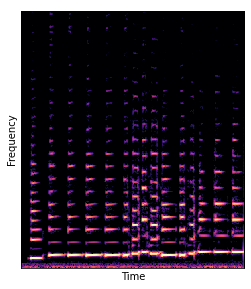

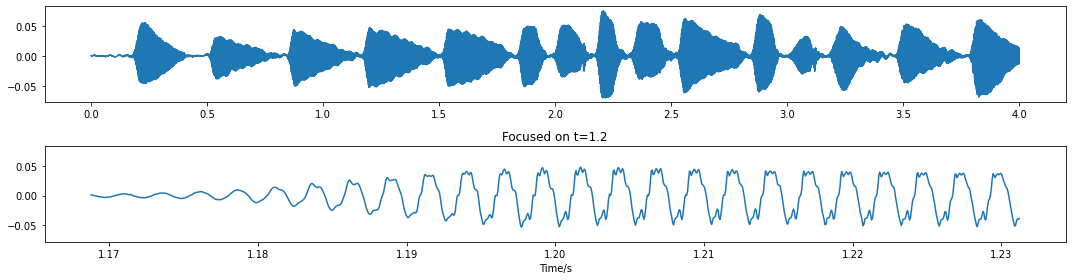

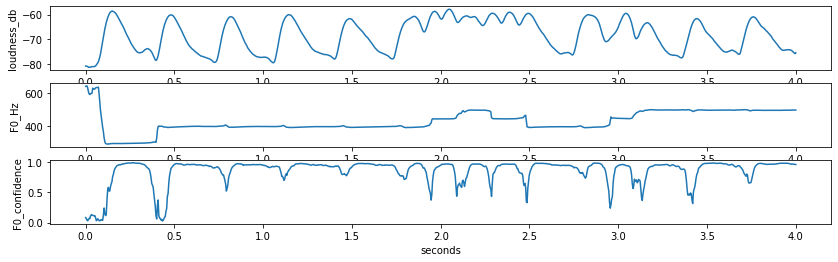

In [2]:
%load_ext autoreload
%autoreload 2

from ddsp.colab import jupyter_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np

TRAIN_TFRECORD_FILEPATTERN = "/Users/p378593/Documents/URMP/mini-urmp-mono/*"
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
print(data_provider is ddsp.training.data.DataProvider)
dataset = data_provider.get_batch(4)

for i in iter(dataset):
    for k, v in i.items():
        print(k, v.shape)
    break

try:
    ex = next(iter(dataset))
except StopIteration:
    raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

ex = next(iter(dataset))
jupyter_utils.show_audio(ex['audio'][0])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'][0])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')

ax[1].plot(x, ex['f0_hz'][0])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'][0])

# Init Model

In [ ]:
%reload_ext tensorboard
import tensorboard as tb
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers, discriminator)
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds


SAVE_DIR = "artifacts/tmp"

# tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

sample_rate = 16000
n_samples = 4*sample_rate

strategy = train_util.get_strategy()

with strategy.scope():
    TIME_STEPS = 1000

    # Create Neural Networks.
    preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

    decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                    rnn_type = 'gru',
                                    ch = 256,
                                    layers_per_stack = 1,
                                    input_keys = ('ld_scaled', 'f0_scaled', 'z'),
                                    output_splits = (('amps', 1),
                                                    ('harmonic_distribution', 45),
                                                    ('noise_magnitudes', 45)))

    # Create Processors.
    harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                    sample_rate=sample_rate,
                                    name='harmonic')

    noise = ddsp.synths.FilteredNoise(window_size=0,
                                    initial_bias=-10.0,
                                    name='noise')
    add = ddsp.processors.Add(name='add')

    # Create ProcessorGroup.
    dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
        (noise, ['noise_magnitudes']),
        (add, ['noise/signal', 'harmonic/signal'])]

    processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                    name='processor_group')


    # Loss_functions
    spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                            mag_weight=1.0,
                                            logmag_weight=1.0)
    
    encoder = encoders.MfccTimeConstantRnnEncoder(rnn_channels = 512, rnn_type = 'gru', z_dims = 16, z_time_steps = 125)
    
    critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio', 'f0_hz', 'loudness_db'])
    model = models.Autoencoder(preprocessor=preprocessor,
                                encoder=encoder,
                                decoder=decoder,
                                processor_group=processor_group,
                                discriminator=critic,
                                losses=[spectral_loss])
    trainer = trainers.Trainer(model, strategy, learning_rate=1e-3)
    dataset = trainer.distribute_dataset(dataset)
    trainer.build(next(iter(dataset)))
    dataset_iter = iter(dataset)
    
    for i in range(3000):
        losses = trainer.train_step(dataset_iter)
        res_str = 'step: {}\t'.format(i)
        for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
        print(res_str)

        if i % 300 == 1:
            print(f"Step {i}")
            trainer.save(SAVE_DIR)

[autoreload of ddsp.training.encoders failed: Traceback (most recent call last):
  File "/Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/p378593/miniconda3/envs/ddsp/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/p378593/miniconda3/envs/ddsp/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/p378593/Documents/ddsp/ddsp/training/encoders.py", line 68, in <module>
    class MfccTimeDistributed

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


RnnFcDecoder:
{'ld_scaled': TensorShape([4, 1000, 1]), 'f0_scaled': TensorShape([4, 1000, 1]), 'z': TensorShape([4, 1000, 16])}
RnnFcDecoder:
{'ld_scaled': TensorShape([4, 1000, 1]), 'f0_scaled': TensorShape([4, 1000, 1]), 'z': TensorShape([4, 1000, 16])}
Model: "autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
f0_loudness_preprocessor_1 ( multiple                  0         
_________________________________________________________________
mfcc_time_constant_rnn_encod multiple                  844365    
_________________________________________________________________
rnn_fc_decoder_1 (RnnFcDecod multiple                  1081179   
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
_________________________________________________________________
spectral_loss (SpectralLoss) multiple                  0     

In [ ]:
n